In [1]:
# Install necessary requirements
# !pip install matplotlib
# !pip install pandas
# !pip install pillow
# !pip install scipy
# !pip install keras


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import random
import numpy as np
import cv2
import joblib
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, DenseNet121, MobileNetV3Large, EfficientNetV2S
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, Model
from tensorflow.keras.metrics import AUC
from tensorflow.image import ssim
from tensorflow.keras.layers import Lambda
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity


Check if TPU is available

In [3]:
# Check if a TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU detected and initialized.")
except ValueError:
    # No TPU found, specify GPU or CPU here
    use_gpu = True  # Set this to True to use GPU or False to use CPU
    if use_gpu and tf.config.list_physical_devices("GPU"):
        strategy = tf.distribute.MirroredStrategy()  # Use GPU
        print("Using GPU for TensorFlow computations.")
    else:
        strategy = tf.distribute.get_strategy()  # Use CPU
        print("Using CPU for TensorFlow computations.")

# Now you can define and run your TensorFlow model using the selected strategy

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using GPU for TensorFlow computations.


In [4]:
def show_img(path):
    image_path = path
    img = mpimg.imread(image_path)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()

def read_csv_to_df(path):
    file_path =  path

    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    return df

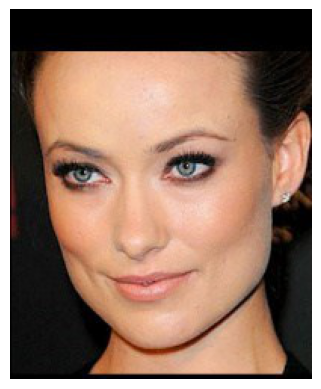

In [5]:
show_img('dataset/train/left/abn.jpg')
train_pairing_df = read_csv_to_df('dataset/train.csv')
test_candidates_df = read_csv_to_df('dataset/test_candidates.csv')
archive_images_df = read_csv_to_df('archive/votes.csv')

1.  Load Training data and augment it
2.  Load Testing data

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale pixel values to [0, 1]
    rotation_range=0,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift image width by up to 20%
    height_shift_range=0.2, # Randomly shift image height by up to 20%
    shear_range=0.2,        # Shear transformations
    zoom_range=0.0,         # Randomly zoom in on images by up to 20%
    horizontal_flip=False,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill mode for newly created pixels
)

test_datagen = ImageDataGenerator(
    rescale=1./255)

# Set the batch size and image size
batch_size = 32
image_size = (245,200)



Now Pair up the left and right images 
1. The  Data format will be  [Left,[Right1, Right2 ....]] In here the Right1 will be the similar image


In [7]:
def load_and_preprocess_image(image_path, target_size=(224,224), random_transform=False):
    # Open the image using Pillow (PIL)
    img = load_img(image_path, target_size=target_size)

    img = img.resize(target_size)

    img = img_to_array(img, dtype='uint8')


    if random_transform:
        img = train_datagen.random_transform(img)

    return img

def create_train_valid_dataset(random_transform, num_right_images=20):
    # Create a list to store the dataset
    dataset = []

    # Iterate through the rows of the CSV file and load/preprocess the images
    for index, row in train_pairing_df.iterrows():
        left_image = load_and_preprocess_image(f"dataset/train/left/{row['left']}.jpg", random_transform=random_transform)

        # Load and preprocess similar image
        similar_image = load_and_preprocess_image(f"dataset/train/right/{row['right']}.jpg", random_transform=random_transform)

        # Load and preprocess additional dissimilar images
        right_images = [similar_image] # put similar image at index 0

        for i in range(num_right_images-1):
            right_idx = random.randint(0, len(train_pairing_df) - 1)

            # Ensure the right right image is different from the similar image
            while right_idx == index:
                right_idx = random.randint(0, len(train_pairing_df) - 1)

            right_image = load_and_preprocess_image(f"dataset/train/right/{train_pairing_df.iloc[right_idx]['right']}.jpg", random_transform=random_transform)
            right_images.append(right_image)

        # Create a data entry containing the left image, list of right images, and the index of the similar image
        data_entry = [left_image, right_images]
        dataset.append(data_entry)

    return dataset

def create_train_valid_dataset_archive(random_transform, num_right_images=20):
    # Create lists to store paired left and right images
    image_pairs_with_label = []

    # Define the directory path where your images are located
    left_image_directory = 'archive/left/left/'  # Update with the correct directory path
    right_image_directory = 'archive/right/right/'  # Update with the correct directory path

    # Define the range for generating random indices
    min_idx = 1
    max_idx = 6015

    # Iterate through the rows of the CSV file and load/preprocess the images
    for index, row in archive_images_df.iterrows():
        # Generate the filename based on the index (e.g., '00000.jpg', '00001.jpg', etc.)
        image_filename = f"{index + 1:05d}.jpg"

        # Construct the full paths to the left and right images
        left_image_path = os.path.join(left_image_directory, image_filename)
        right_image_path = os.path.join(right_image_directory, image_filename)

        # Check if both image files exist
        if os.path.exists(left_image_path) and os.path.exists(right_image_path) and row['wins']>row['fails']:
            # Load and preprocess the left image
            left_image = load_and_preprocess_image(left_image_path, random_transform=random_transform)

            # Load and preprocess the right image
            right_image = load_and_preprocess_image(right_image_path, random_transform=random_transform)

            # Create a pair with left image and a list of right images
            image_pair_with_label = [left_image, [right_image]]

            # Add random dissimilar right images to the list
            for _ in range(num_right_images - 1):  # Subtract 1 to account for the similar right image
                random_idx = random.randint(min_idx, max_idx)
                while random_idx == index + 1:  # Ensure the dissimilar image is not the same as the left image
                    random_idx = random.randint(min_idx, max_idx)
                dissimilar_image_filename = f"{random_idx:05d}.jpg"
                dissimilar_image_path = os.path.join(right_image_directory, dissimilar_image_filename)
                dissimilar_image = load_and_preprocess_image(dissimilar_image_path, random_transform=random_transform)
                image_pair_with_label[1].append(dissimilar_image)

            image_pairs_with_label.append(image_pair_with_label)
        else:
            print(f"Image files not found for index {index + 1}: {left_image_path}, {right_image_path}")


    return image_pairs_with_label

def display_image_pair(image_pair):
    left_image, right_images = image_pair
    num_right_images = len(right_images)
    
    max_images_per_row = 10  # Maximum number of images to display in a single row

    num_rows = (num_right_images - 1) // max_images_per_row + 1  # Calculate the number of rows

    plt.figure(figsize=(15, 5 * num_rows))

    for i in range(num_rows):
        start_idx = i * max_images_per_row
        end_idx = min((i + 1) * max_images_per_row, num_right_images)
        
        row_right_images = right_images[start_idx:end_idx]

        plt.subplot(num_rows, max_images_per_row + 1, i * (max_images_per_row + 1) + 1)
        plt.imshow(left_image)
        plt.title("Left Image")
        plt.axis("off")

        for j, right_image in enumerate(row_right_images):
            plt.subplot(num_rows, max_images_per_row + 1, i * (max_images_per_row + 1) + j + 2)
            plt.imshow(right_image)
            plt.title(f"Right Image {start_idx + j + 1}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


Pair up images with similar and dissimilar
Show examples

In [8]:
# Define a function to create and save the dataset if loading fails
def create_and_save_combined_dataset():
    train_valid_offical_dataset = create_train_valid_dataset(True, 20)
    train_valid_outside_dataset = create_train_valid_dataset_archive(True, 20)
    train_valid_dataset = train_valid_offical_dataset + train_valid_outside_dataset

    # Save data
    joblib.dump(train_valid_dataset, 'F:/cv_data/train_valid_dataset.joblib')

# Try to load the dataset
try:
    train_valid_dataset = joblib.load('F:/cv_data/train_valid_dataset.joblib')
    print(f"Loaded dataset size is {len(train_valid_dataset)}")
except FileNotFoundError:
    print("Dataset not found, creating and saving...")
    create_and_save_combined_dataset()
    train_valid_dataset = joblib.load('F:/cv_data/train_valid_dataset.joblib')
    print(f"Created and saved dataset size is {len(train_valid_dataset)}")

# Now you have the dataset loaded or created, and you can work with it as needed.
print(train_valid_dataset[6000][0].shape)
display_image_pair(train_valid_dataset[6000])

KeyboardInterrupt: 

Now extract features using libraries. Such as local features

In [ ]:
def show_local_features(detector, image):
    img = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2BGR)

    key_points, description = detector.detectAndCompute(img, None)
    img_keypoints = cv2.drawKeypoints(img, 
                                            key_points, 
                                            img, 
                                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Draw circles.
    rgb = cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.title('detector Interest Points')
    plt.imshow(rgb); plt.show()

def image_detect_and_compute(detector, img_name):
    """Detect and compute interest points and their descriptors."""
    img = cv2.cvtColor(img_name.astype(np.uint8), cv2.COLOR_RGB2BGR)
    kp, des = detector.detectAndCompute(img, None)
    return img, kp, des
    

def draw_image_matches(detector, image_pair, distance_threshold = 0.75):
    """Draw ORB feature matches of the given two images."""

    img1, kp1, des1 = image_detect_and_compute(detector, image_pair[0])
    img2, kp2, des2 = image_detect_and_compute(detector, image_pair[1])
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < distance_threshold*n.distance:
            good.append([m])
    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb),plt.show()
    

Show some local feautres and match features

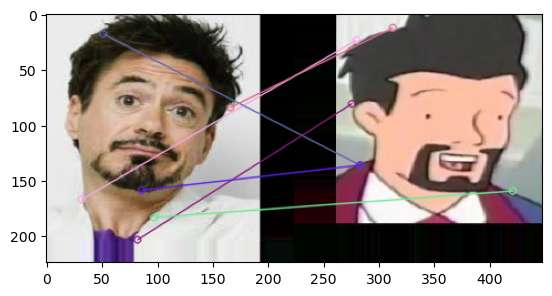

In [ ]:
orb = cv2.ORB_create()
sift = cv2.SIFT_create()

# show_local_features(sift,train_valid_dataset[5][0][0])
draw_image_matches(sift, [train_valid_dataset[5][0],train_valid_dataset[5][1][0]])

Extract features from pretrained model like ResNet 

In [12]:
def extract_features(x,model):
    
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Extract features from the image
    features = model.predict(x,verbose = 0)

    return features

def visualize_feature_maps(features, number_of_feature_to_show=10, figsize=(10, 10), cmap='viridis'):
    num_features = features.shape[-1]
    num_rows = (num_features + 4) // 5  # Calculate the number of rows needed

    plt.figure(figsize=figsize)
    for i in range(number_of_feature_to_show):
        if i < num_features:
            plt.subplot(num_rows, 5, i + 1)
            feature_map = features[0, :, :, i]

            # Resize the feature map for better visualization
            resized_feature_map = cv2.resize(feature_map, (200, 200))
            plt.imshow(resized_feature_map, cmap=cmap, interpolation='nearest')
            plt.axis('off')
            plt.title(f'Feature {i + 1}')

    plt.suptitle(f'Feature Maps Visualization', fontsize=16)
    plt.tight_layout()
    plt.show()


def calculate_cosine_distance(left_image, right_image,model):
    left_image = extract_features(left_image,model)
    right_image = extract_features(right_image,model)
    return cosine_similarity([left_image.flatten()], [right_image.flatten()])[0][0]



Create model

In [13]:
def create_siamese_with_model(input_shape, base_model, unfreeze_layer_number=0, num_right_inputs=1):
    # Load a pre-trained base model
    base_cnn = base_model
    # Freeze the layers of the pre-trained base model
    for layer in base_cnn.layers:
        layer.trainable = False

    if unfreeze_layer_number > 0:
        # Unfreeze specified number of layers
        for layer in base_cnn.layers[-unfreeze_layer_number:]:
            layer.trainable = True
    
    # Extract features using the base model
    input_image = tf.keras.layers.Input(shape=input_shape)
    features = base_cnn(input_image)

    # Define the Siamese network on top of the extracted features
    flatten = layers.Flatten()(features)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense1 = layers.Dropout(0.5)(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)

    embedding = models.Model(input_image, output, name="Embedding")

    # Define the Siamese network
    input_left = tf.keras.layers.Input(shape=input_shape, name="left_input")
    input_right = [tf.keras.layers.Input(shape=input_shape, name=f"right_input_{i}") for i in range(num_right_inputs)]
    output_left = embedding(input_left)
    output_right = [embedding(right_input) for right_input in input_right]

    # Calculate similarity score (e.g., cosine similarity) for each pair
    similarity_scores = [layers.Dot(axes=-1, normalize=True)([output_left, right]) for right in output_right]

    siamese_model = models.Model(inputs=[input_left] + input_right, outputs=similarity_scores)

    return siamese_model


Define all base models

In [16]:
# Define the input shape
input_shape = (224,224, 3)

DenseNet121_model = DenseNet121(
    weights="imagenet",
    input_shape=input_shape,
    include_top=True,
)

VGG16_model = VGG16(
    weights="imagenet",
    input_shape=input_shape,
    include_top=True,
)

VGG19_model = VGG19(
    weights="imagenet",
    input_shape=input_shape,
    include_top=True,
)

ResNet50_model = ResNet50(
    weights="imagenet",
    input_shape=input_shape,
    include_top=True,
)

MobileNetV3Large_model = MobileNetV3Large(
    weights="imagenet",
    input_shape=input_shape,
    include_top=True,
)

EfficientNetV2S_model = EfficientNetV2S(
    weights="imagenet",
    input_shape=input_shape,
    include_top=False,
)

To find out the performance of each different pretrained models

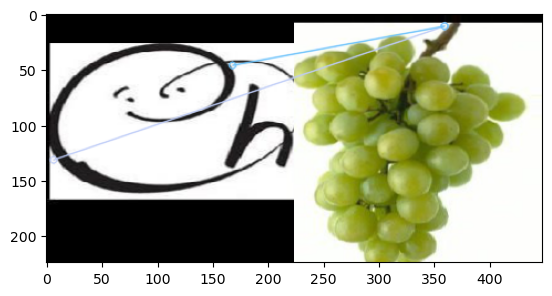

training size is 5956
VGG16 cosine score is 0.03332104533910751
VGG19 cosine score is 0.02292134054005146
DenseNet121 cosine score is 0.0064389766193926334
ResNet50 cosine score is 0.033175017684698105


In [23]:
# Split the dataset into training and validation sets (e.g., 80% for training, 20% for validation)
train_pairs, valid_pairs = train_test_split(train_valid_dataset, test_size=0.2, random_state=42)

def process_pairs(pair_list):
    left_images = []
    right_images = []
    labels = []

    for pair in pair_list:
        left_image, right_images_list = pair[0], pair[1]

        for i, right_image in enumerate(right_images_list):
            left_images.append(left_image)
            right_images.append(right_image)
            labels.append(1 if i == 0 else 0)

    return np.array(left_images), np.array(right_images), np.array(labels)

# Process training and validation data
train_left_images, train_right_images, train_labels = process_pairs(train_pairs)
valid_left_images, valid_right_images, valid_labels = process_pairs(valid_pairs)

left_image = train_pairs[30][0]
right_image = train_pairs[30][1][1]

draw_image_matches(sift, [left_image,right_image])
print(f"training size is {len(train_pairs)}")
print(f"VGG16 cosine score is {calculate_cosine_distance(left_image,right_image,VGG16_model)}")
print(f"VGG19 cosine score is {calculate_cosine_distance(left_image,right_image,VGG19_model)}")
print(f"DenseNet121 cosine score is {calculate_cosine_distance(left_image,right_image,DenseNet121_model)}")
print(f"ResNet50 cosine score is {calculate_cosine_distance(left_image,right_image,ResNet50_model)}")
print(f"MobileNetV3Large cosine score is {calculate_cosine_distance(left_image,right_image,MobileNetV3Large_model)}")
print(f"EfficientNetV2S cosine score is {calculate_cosine_distance(left_image,right_image,EfficientNetV2S_model)}")

In [95]:
# # Initialize variables for similarity and dissimilarity for each model
# total_similarity = {model_name: 0.0 for model_name in ['DenseNet121', 'VGG16', 'VGG19', 'ResNet50']}
# total_dissimilarity = {model_name: 0.0 for model_name in ['DenseNet121', 'VGG16', 'VGG19', 'ResNet50']}
# valid_pair_count = {model_name: 0 for model_name in ['DenseNet121', 'VGG16', 'VGG19', 'ResNet50']}

# # Define the list of models
# models = {
#     'DenseNet121': DenseNet121_model,
#     'VGG16': VGG16_model,
#     'VGG19': VGG19_model,
#     'ResNet50': ResNet50_model
# }

# # Iterate through the dataset and calculate similarity/dissimilarity for each model
# for pair, label in train_valid_dataset:
#     left_image = pair[0]
#     right_image = pair[1]

#     for model_name, model in models.items():
#         if label == 1:
#             # Perform any necessary preprocessing on left_image and right_image
#             similarity = calculate_cosine_distance(left_image, right_image, model)
#             # Update total_similarity and valid_pair_count for the specific model
#             total_similarity[model_name] += similarity
#             valid_pair_count[model_name] += 1
#         else:
#             # Calculate dissimilarity for the specific model
#             dissimilarity = calculate_cosine_distance(left_image, right_image, model)
#             # Update total_dissimilarity for the specific model
#             total_dissimilarity[model_name] += dissimilarity

# # Calculate average similarity and average dissimilarity for each model
# average_similarity = {model_name: total_similarity[model_name] / valid_pair_count[model_name] if valid_pair_count[model_name] > 0 else 0.0 for model_name in models}
# average_dissimilarity = {model_name: total_dissimilarity[model_name] / (len(train_valid_dataset) - valid_pair_count[model_name]) if (len(train_valid_dataset) - valid_pair_count[model_name]) > 0 else 0.0 for model_name in models}

# # Print the results for all models
# for model_name in models:
#     print(f"Average Cosine Similarity for Valid Pairs ({model_name}): {average_similarity[model_name]}")
#     print(f"Average Cosine Dissimilarity for Invalid Pairs ({model_name}): {average_dissimilarity[model_name]}")


Average Cosine Similarity for Valid Pairs (DenseNet121): 0.6408264414817095
Average Cosine Dissimilarity for Invalid Pairs (DenseNet121): 0.6149117222204804
Average Cosine Similarity for Valid Pairs (VGG16): 0.18250333527848125
Average Cosine Dissimilarity for Invalid Pairs (VGG16): 0.12083680482348427
Average Cosine Similarity for Valid Pairs (VGG19): 0.18792922325571998
Average Cosine Dissimilarity for Invalid Pairs (VGG19): 0.12308166390401311
Average Cosine Similarity for Valid Pairs (ResNet50): 0.23497135157324373
Average Cosine Dissimilarity for Invalid Pairs (ResNet50): 0.16812637484818696


In [20]:
# Create the Siamese network
siamese_model = create_siamese_with_model(input_shape,base_model=VGG16_model,unfreeze_layer_number=0)
# Compile the model
siamese_model.compile(loss='binary_crossentropy', optimizer=Adam(0.00001), metrics=['accuracy'])
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input_0 (InputLayer)     [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Embedding (Functional)         (None, 256)          139070248   ['left_input[0][0]',             
                                                                  'right_input_0[0][0]']      

In [93]:
num_epochs = 10  # Adjust the number of epochs as needed
batch_size = 32  # Adjust the batch size as needed

In [20]:
history = siamese_model.fit(
    [train_left_images] + [train_right_images[:, i] for i in range(20)],train_labels,
    validation_data=([valid_left_images] + [valid_right_images[:, i] for i in range(20)],, valid_labels),
    epochs=num_epochs,
    batch_size=batch_size,
)

Epoch 1/10


150/150 [==============================] - 136s 570ms/step - loss: 2.6696 - auc: 0.5569 - val_loss: 1.6718 - val_auc: 0.6305
Epoch 2/10
150/150 [==============================] - 82s 546ms/step - loss: 2.6311 - auc: 0.5807 - val_loss: 1.4421 - val_auc: 0.6162
Epoch 3/10
150/150 [==============================] - 89s 595ms/step - loss: 2.5686 - auc: 0.5827 - val_loss: 1.4773 - val_auc: 0.6189
Epoch 4/10
131/150 [=========================>....] - ETA: 9s - loss: 2.4405 - auc: 0.6070 

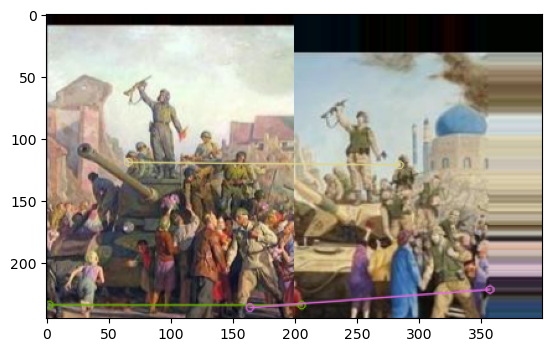

(245, 200, 3)
1/1 [==============================] - 2s 2s/step
[[0.54612505]]


In [ ]:
left_img_array = np.array(train_valid_dataset[250][0][0])
right_img_array = np.array(train_valid_dataset[250][0][1])

draw_image_matches(sift, train_valid_dataset[250][0])
print(left_img_array.shape)

left_img_array = np.expand_dims(left_img_array, axis=0)
right_img_array = np.expand_dims(right_img_array, axis=0)
similarity_score = siamese_model.predict([left_img_array, right_img_array])
print(similarity_score)

In [ ]:
def show_test_case(model,row_number=10):
    for index, row in test_candidates_df.iterrows():
        if index >= row_number:
            break

        print(f"Row {index}")
        max_similarity_score = -1  # Initialize max_similarity_score to a very low value
        best_left_img = None
        best_right_img = None

        for column, value in row.items():
            print(f"  Column {column}: {value}")
            if column == 'left':
                test_img_left = load_and_preprocess_image(f"dataset/test/left/{value}.jpg")
            else:
                test_img_right = load_and_preprocess_image(f"dataset/test/right/{value}.jpg")
                left_img_array = np.expand_dims(test_img_left, axis=0)
                right_img_array = np.expand_dims(test_img_right, axis=0)

                # Calculate the similarity score
                similarity_score = model.predict([left_img_array, right_img_array],verbose=0)
                print(similarity_score)
                if similarity_score > max_similarity_score:
                    max_similarity_score = similarity_score
                    best_left_img = test_img_left
                    best_right_img = test_img_right

        # Draw image matches with the highest similarity score
        draw_image_matches(sift, [best_left_img, best_right_img])
        print(f"Highest Similarity Score: {max_similarity_score}")


Row 0
  Column left: abm
  Column c0: kyr
[[0.6976081]]
  Column c1: qqo
[[0.6242132]]
  Column c2: xpv
[[0.7448379]]
  Column c3: tnd
[[0.6884]]
  Column c4: xal
[[0.6265328]]
  Column c5: pvr
[[0.6730555]]
  Column c6: nsb
[[0.6898259]]
  Column c7: yzv
[[0.725967]]
  Column c8: ahb
[[0.6553529]]
  Column c9: mlm
[[0.70501804]]
  Column c10: drb
[[0.6821725]]
  Column c11: vqu
[[0.69008815]]
  Column c12: vzr
[[0.6698408]]
  Column c13: kxe
[[0.6168705]]
  Column c14: mdq
[[0.6542907]]
  Column c15: oai
[[0.6876954]]
  Column c16: nmm
[[0.64624685]]
  Column c17: yzu
[[0.67927265]]
  Column c18: ihk
[[0.6786795]]
  Column c19: zwv
[[0.71597934]]


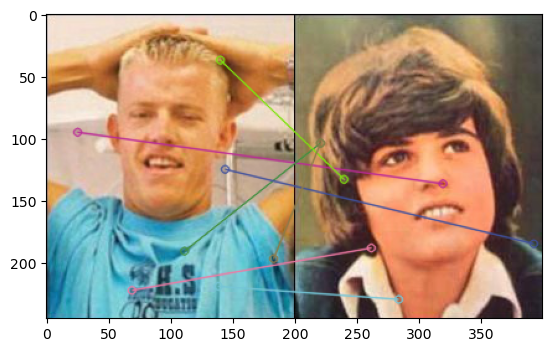

Highest Similarity Score: [[0.7448379]]
Row 1
  Column left: aci
  Column c0: jzn
[[0.6776757]]
  Column c1: hxw
[[0.759623]]
  Column c2: iaj
[[0.689363]]
  Column c3: edq
[[0.7139889]]
  Column c4: huu
[[0.6457904]]
  Column c5: huk
[[0.67928064]]
  Column c6: owo
[[0.7380707]]
  Column c7: ntd
[[0.67152965]]
  Column c8: uhk
[[0.6095326]]
  Column c9: ojv
[[0.7481245]]
  Column c10: mhg
[[0.7120799]]
  Column c11: exb
[[0.6404108]]
  Column c12: pny
[[0.7097259]]
  Column c13: kbo
[[0.70921874]]
  Column c14: tdb
[[0.69909525]]
  Column c15: sok
[[0.666113]]
  Column c16: zsq
[[0.66329396]]
  Column c17: yfg
[[0.6834202]]
  Column c18: iqx
[[0.7218684]]
  Column c19: jnj
[[0.6687198]]


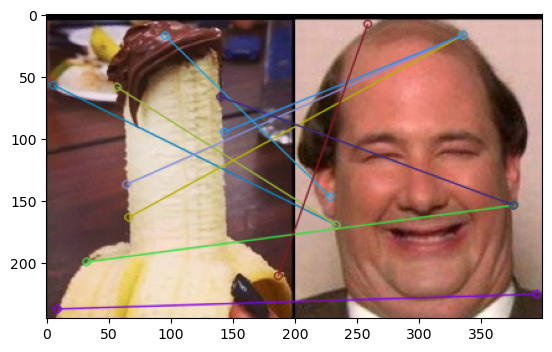

Highest Similarity Score: [[0.759623]]
Row 2
  Column left: acn
  Column c0: ksm
[[0.67449784]]
  Column c1: tyj
[[0.6302111]]
  Column c2: hhy
[[0.699981]]
  Column c3: rph
[[0.64544517]]
  Column c4: axt
[[0.742313]]
  Column c5: dby
[[0.6790129]]
  Column c6: xiv
[[0.6608062]]
  Column c7: aoc
[[0.6605668]]
  Column c8: oxb
[[0.62222207]]
  Column c9: iyw
[[0.6811402]]
  Column c10: vsu
[[0.6167978]]
  Column c11: wrx
[[0.6387403]]
  Column c12: zem
[[0.5259051]]
  Column c13: rkq
[[0.65796405]]
  Column c14: vjq
[[0.6494862]]
  Column c15: duq
[[0.6730938]]
  Column c16: ncp
[[0.67541116]]
  Column c17: mst
[[0.67038727]]
  Column c18: wzd
[[0.69848824]]
  Column c19: gup
[[0.66506493]]


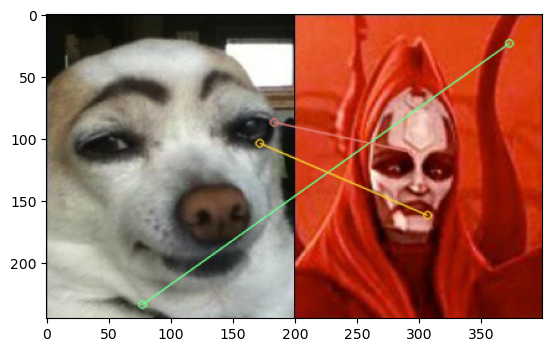

Highest Similarity Score: [[0.742313]]
Row 3
  Column left: aco
  Column c0: tft
[[0.6630481]]
  Column c1: bxn
[[0.6603186]]
  Column c2: vkl
[[0.6946799]]
  Column c3: mdq
[[0.6603849]]
  Column c4: iqb
[[0.68318963]]
  Column c5: uev
[[0.7499889]]
  Column c6: mjn
[[0.7385303]]
  Column c7: ccy
[[0.6229538]]
  Column c8: nje
[[0.6636907]]
  Column c9: jsj
[[0.68476623]]
  Column c10: flo
[[0.6981344]]
  Column c11: ltz
[[0.6834321]]
  Column c12: sjz
[[0.633589]]
  Column c13: ind
[[0.5944147]]
  Column c14: fbw
[[0.6696096]]
  Column c15: ahy
[[0.7108793]]
  Column c16: vwe
[[0.58530575]]
  Column c17: cog
[[0.71246195]]
  Column c18: xcj
[[0.71910447]]
  Column c19: boz
[[0.6891361]]


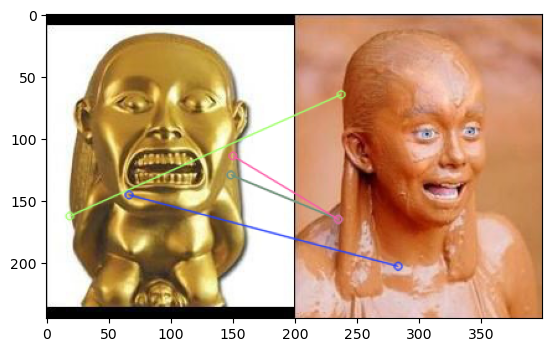

Highest Similarity Score: [[0.7499889]]
Row 4
  Column left: acu
  Column c0: apn
[[0.70174766]]
  Column c1: zip
[[0.683887]]
  Column c2: cxx
[[0.70145774]]
  Column c3: cwh
[[0.73266697]]
  Column c4: wbu
[[0.7320173]]
  Column c5: azy
[[0.70314014]]
  Column c6: qoe
[[0.5903701]]
  Column c7: wnd
[[0.74033725]]
  Column c8: xoo
[[0.69353724]]
  Column c9: oxh
[[0.67638165]]
  Column c10: zwq
[[0.7111314]]
  Column c11: rqi
[[0.700956]]
  Column c12: rei
[[0.7040969]]
  Column c13: poj
[[0.71341264]]
  Column c14: gos
[[0.6811264]]
  Column c15: hif
[[0.65462613]]
  Column c16: ami
[[0.6772585]]
  Column c17: fhc
[[0.74994457]]
  Column c18: ift
[[0.6903615]]
  Column c19: xcj
[[0.7032407]]


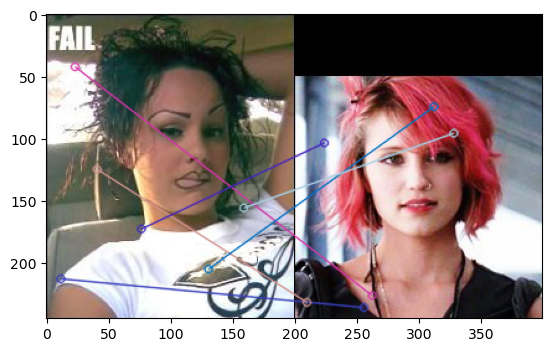

Highest Similarity Score: [[0.74994457]]
Row 5
  Column left: acw
  Column c0: igh
[[0.62113166]]
  Column c1: ljl
[[0.7201277]]
  Column c2: vkl
[[0.65220577]]
  Column c3: kif
[[0.67450583]]
  Column c4: rhb
[[0.72741544]]
  Column c5: mov
[[0.6781909]]
  Column c6: fva
[[0.6661288]]
  Column c7: vwe
[[0.5673281]]
  Column c8: bks
[[0.66502976]]
  Column c9: xsy
[[0.66309917]]
  Column c10: cfv
[[0.7028831]]
  Column c11: ngu
[[0.6693568]]
  Column c12: fuk
[[0.7042332]]
  Column c13: zwq
[[0.6705675]]
  Column c14: drq
[[0.70812964]]
  Column c15: ggf
[[0.6395576]]
  Column c16: vit
[[0.5936216]]
  Column c17: pts
[[0.681007]]
  Column c18: owk
[[0.7145792]]
  Column c19: iyx
[[0.6570126]]


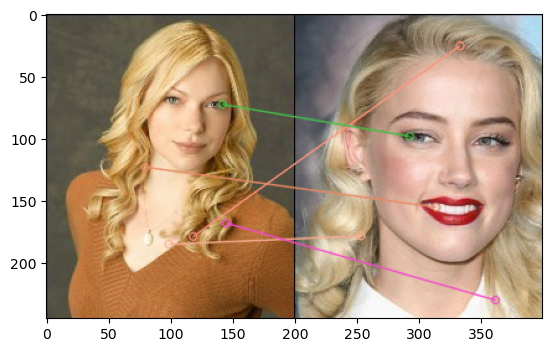

Highest Similarity Score: [[0.72741544]]
Row 6
  Column left: adt
  Column c0: xuj
[[0.71703243]]
  Column c1: kls
[[0.7454885]]
  Column c2: wrt
[[0.681227]]
  Column c3: leq
[[0.68530595]]
  Column c4: teb
[[0.71667206]]
  Column c5: uve
[[0.66459864]]
  Column c6: ciy
[[0.6285724]]
  Column c7: hgv
[[0.6696062]]
  Column c8: tlc
[[0.62846786]]
  Column c9: wfw
[[0.7101055]]
  Column c10: wfm
[[0.6560856]]
  Column c11: kqt
[[0.64475054]]
  Column c12: rqc
[[0.64376336]]
  Column c13: sok
[[0.70153594]]
  Column c14: ymn
[[0.6390046]]
  Column c15: zma
[[0.685796]]
  Column c16: ark
[[0.673861]]
  Column c17: xdu
[[0.6553627]]
  Column c18: pjl
[[0.7220856]]
  Column c19: aby
[[0.6061274]]


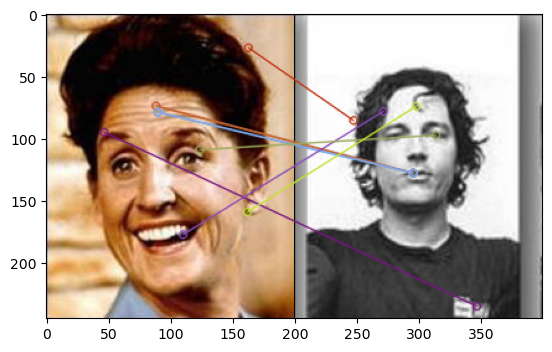

Highest Similarity Score: [[0.7454885]]
Row 7
  Column left: aei
  Column c0: lec
[[0.6659378]]
  Column c1: mrg
[[0.57591325]]
  Column c2: foj
[[0.5574378]]
  Column c3: nrf
[[0.63549584]]
  Column c4: lpo
[[0.7179314]]
  Column c5: aoo
[[0.73694223]]
  Column c6: euf
[[0.63395715]]
  Column c7: edm
[[0.68226886]]
  Column c8: dgu
[[0.6550988]]
  Column c9: uml
[[0.64814293]]
  Column c10: nlx
[[0.71366143]]
  Column c11: san
[[0.6559146]]
  Column c12: joy
[[0.69183254]]
  Column c13: xsw
[[0.6368879]]
  Column c14: cop
[[0.66037786]]
  Column c15: mvk
[[0.6378928]]
  Column c16: vze
[[0.6249738]]
  Column c17: xlj
[[0.78488445]]
  Column c18: aqv
[[0.6295595]]
  Column c19: xic
[[0.7281935]]


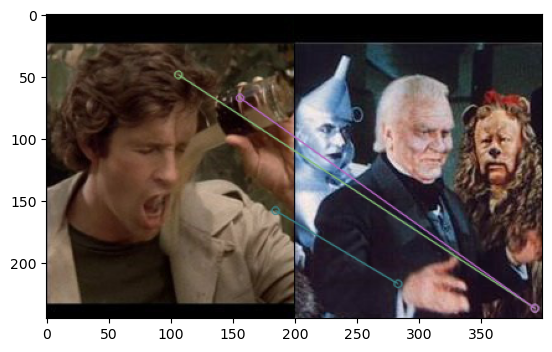

Highest Similarity Score: [[0.78488445]]
Row 8
  Column left: aej
  Column c0: mch
[[0.73847055]]
  Column c1: uqi
[[0.7325176]]
  Column c2: lcm
[[0.6291666]]
  Column c3: wvk
[[0.67449677]]
  Column c4: gyt
[[0.665991]]
  Column c5: rhi
[[0.6764619]]
  Column c6: ltz
[[0.659128]]
  Column c7: xhj
[[0.6137416]]
  Column c8: imt
[[0.7108616]]
  Column c9: csy
[[0.6570612]]
  Column c10: zsn
[[0.6801894]]
  Column c11: kdd
[[0.72851694]]
  Column c12: vxu
[[0.6908932]]
  Column c13: bxn
[[0.6958543]]
  Column c14: xyn
[[0.7096356]]
  Column c15: mzy
[[0.6987483]]
  Column c16: xji
[[0.722427]]
  Column c17: bdh
[[0.657336]]
  Column c18: jzh
[[0.69411874]]
  Column c19: frq
[[0.7099776]]


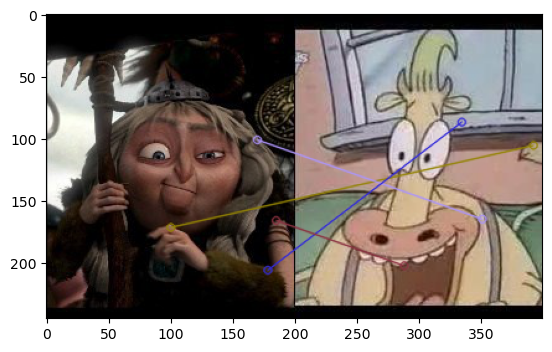

Highest Similarity Score: [[0.73847055]]
Row 9
  Column left: aem
  Column c0: hdu
[[0.75217164]]
  Column c1: mdv
[[0.6920838]]
  Column c2: xis
[[0.7258172]]
  Column c3: kep
[[0.6629641]]
  Column c4: omp
[[0.7385989]]
  Column c5: klw
[[0.7169788]]
  Column c6: aoo
[[0.72979194]]
  Column c7: req
[[0.7071719]]
  Column c8: sll
[[0.6786084]]
  Column c9: mjn
[[0.6540792]]
  Column c10: gpd
[[0.7235863]]
  Column c11: mix
[[0.67961633]]
  Column c12: gsk
[[0.67767894]]
  Column c13: asr
[[0.6478489]]
  Column c14: skm
[[0.69773823]]
  Column c15: wxc
[[0.6884647]]
  Column c16: avn
[[0.7867384]]
  Column c17: zuf
[[0.72090924]]
  Column c18: sjz
[[0.6801793]]
  Column c19: vod
[[0.78694844]]


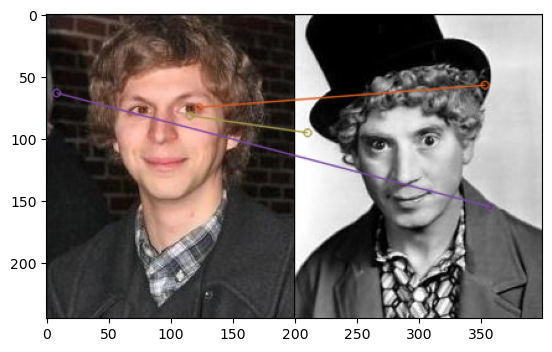

Highest Similarity Score: [[0.78694844]]
Row 10
  Column left: aes
  Column c0: tgp
[[0.7122257]]
  Column c1: gwn
[[0.6683735]]
  Column c2: tur
[[0.6971345]]
  Column c3: cxa
[[0.6611168]]
  Column c4: drq
[[0.72014]]
  Column c5: tde
[[0.72493315]]
  Column c6: kbo
[[0.6719377]]
  Column c7: iaw
[[0.692027]]
  Column c8: hkh
[[0.5965625]]
  Column c9: zto
[[0.6982702]]
  Column c10: egh
[[0.71232134]]
  Column c11: lqt
[[0.71015495]]
  Column c12: edm
[[0.65901315]]
  Column c13: kif
[[0.62460107]]
  Column c14: uac
[[0.74227]]
  Column c15: gow
[[0.76635516]]
  Column c16: udm
[[0.6885116]]
  Column c17: fbr
[[0.7066484]]
  Column c18: rox
[[0.73698086]]
  Column c19: szh
[[0.6876858]]


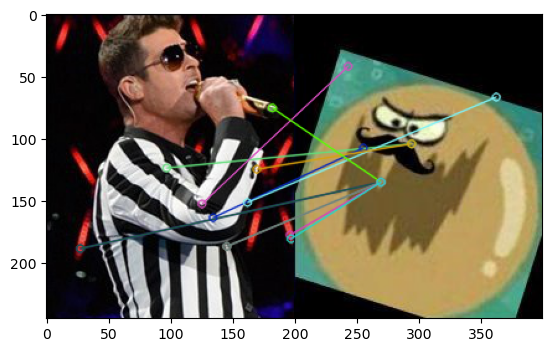

Highest Similarity Score: [[0.76635516]]
Row 11
  Column left: afd
  Column c0: gyt
[[0.621607]]
  Column c1: qbe
[[0.65004283]]
  Column c2: pku
[[0.6346934]]
  Column c3: cwh
[[0.62973905]]
  Column c4: flo
[[0.6530652]]
  Column c5: iue
[[0.6997725]]
  Column c6: lbo
[[0.63410544]]
  Column c7: jzo
[[0.66636693]]
  Column c8: snf
[[0.6881113]]
  Column c9: qmc
[[0.68698144]]
  Column c10: gpk
[[0.6263838]]
  Column c11: qhg
[[0.6677302]]
  Column c12: wdt
[[0.7001047]]
  Column c13: mib
[[0.68588996]]
  Column c14: dqs
[[0.62221974]]
  Column c15: enn
[[0.7036381]]
  Column c16: fqm
[[0.72947675]]
  Column c17: wuh
[[0.69683313]]
  Column c18: rog
[[0.6743554]]
  Column c19: agq
[[0.6164969]]


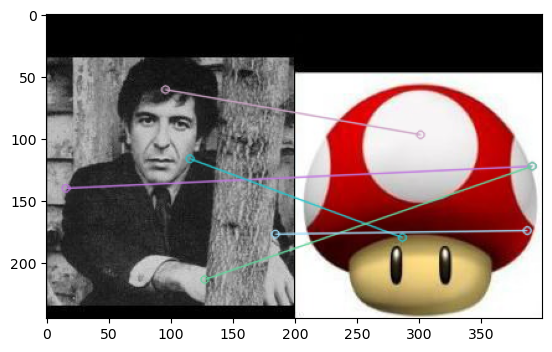

Highest Similarity Score: [[0.72947675]]
Row 12
  Column left: afl
  Column c0: hck
[[0.70420635]]
  Column c1: ezf
[[0.6814842]]
  Column c2: rov
[[0.67607814]]
  Column c3: tmw
[[0.66137135]]
  Column c4: vxs
[[0.6573476]]
  Column c5: owy
[[0.66086453]]
  Column c6: wwb
[[0.65776145]]
  Column c7: wmh
[[0.7150494]]
  Column c8: rkq
[[0.7889237]]
  Column c9: zvj
[[0.6598239]]
  Column c10: uft
[[0.7300458]]
  Column c11: wbk
[[0.7022116]]
  Column c12: wwd
[[0.7482576]]
  Column c13: bvo
[[0.7393156]]
  Column c14: grn
[[0.690404]]
  Column c15: xcm
[[0.7288039]]
  Column c16: rsj
[[0.62544936]]
  Column c17: rad
[[0.7071324]]
  Column c18: cqc
[[0.75279343]]
  Column c19: mlo
[[0.8113165]]


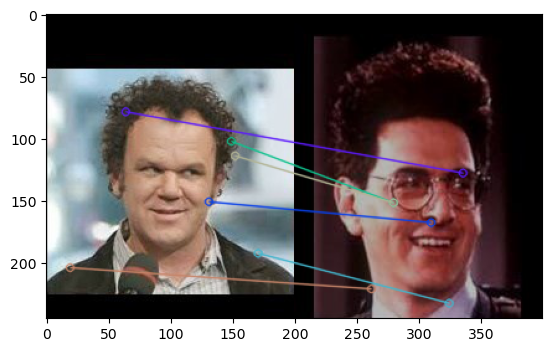

Highest Similarity Score: [[0.8113165]]
Row 13
  Column left: agb
  Column c0: zgx
[[0.6481488]]
  Column c1: pqz
[[0.7062949]]
  Column c2: wmk
[[0.77165604]]
  Column c3: gaq
[[0.702117]]
  Column c4: dhm
[[0.7389218]]
  Column c5: mnv
[[0.676007]]
  Column c6: cwc
[[0.68931395]]
  Column c7: vjx
[[0.79656994]]
  Column c8: kma
[[0.7333946]]
  Column c9: tge
[[0.71768636]]
  Column c10: hwf
[[0.7038719]]
  Column c11: kti
[[0.74513835]]
  Column c12: zem
[[0.5468714]]
  Column c13: kyi
[[0.7317345]]
  Column c14: ftp
[[0.74245906]]
  Column c15: nns
[[0.68895626]]
  Column c16: uah
[[0.74597144]]
  Column c17: swm
[[0.7492522]]
  Column c18: cvn
[[0.74165595]]
  Column c19: chc
[[0.6603078]]


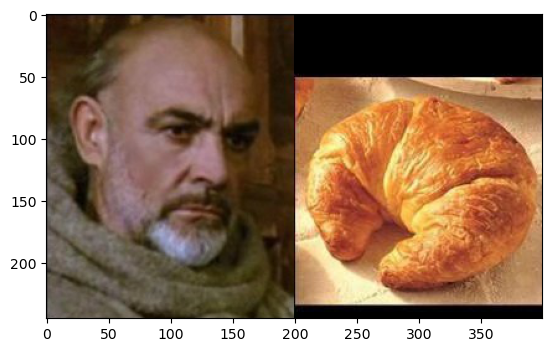

Highest Similarity Score: [[0.79656994]]
Row 14
  Column left: agl
  Column c0: lfb
[[0.7810831]]
  Column c1: ibu
[[0.7471209]]
  Column c2: zwv
[[0.72690773]]
  Column c3: tha
[[0.7462728]]
  Column c4: uea
[[0.7567578]]
  Column c5: lno
[[0.67635465]]
  Column c6: xhv
[[0.6809163]]
  Column c7: hzq
[[0.65089667]]
  Column c8: pzl
[[0.753178]]
  Column c9: rod
[[0.70507103]]
  Column c10: jmm
[[0.72997636]]
  Column c11: iaj
[[0.756163]]
  Column c12: otz
[[0.628383]]
  Column c13: bet
[[0.644299]]
  Column c14: bzo
[[0.67237705]]
  Column c15: akl
[[0.7083406]]
  Column c16: qgs
[[0.6436835]]
  Column c17: fva
[[0.70761865]]
  Column c18: gzv
[[0.6530372]]
  Column c19: nhj
[[0.74979633]]


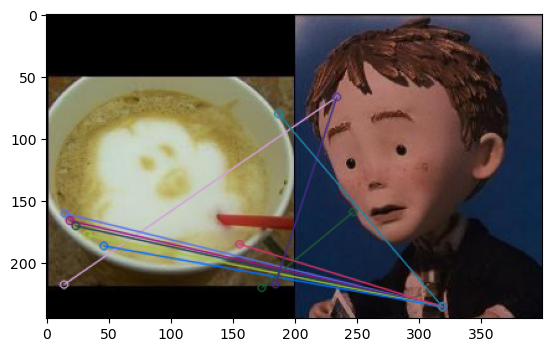

Highest Similarity Score: [[0.7810831]]
Row 15
  Column left: ahg
  Column c0: jez
[[0.7063918]]
  Column c1: jzn
[[0.6640793]]
  Column c2: hxt
[[0.7049427]]
  Column c3: zek
[[0.6981041]]
  Column c4: dxe
[[0.68827903]]
  Column c5: lln
[[0.69013727]]
  Column c6: gow
[[0.72033453]]
  Column c7: bfh
[[0.73164487]]
  Column c8: epl
[[0.6259849]]
  Column c9: okn
[[0.5996341]]
  Column c10: igp
[[0.73936224]]
  Column c11: szi
[[0.7340679]]
  Column c12: gkr
[[0.678726]]
  Column c13: ulq
[[0.71487176]]
  Column c14: crj
[[0.741381]]
  Column c15: swm
[[0.74921143]]
  Column c16: hhk
[[0.7256096]]
  Column c17: flo
[[0.758046]]
  Column c18: kyf
[[0.6581645]]
  Column c19: omj
[[0.6748105]]


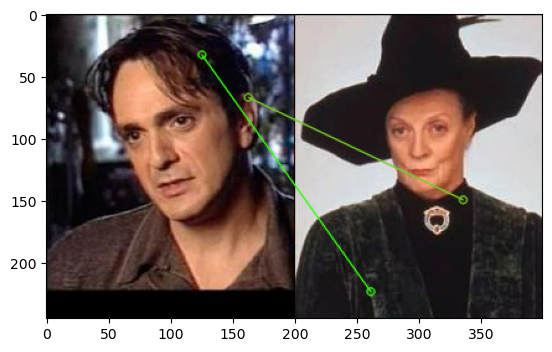

Highest Similarity Score: [[0.758046]]
Row 16
  Column left: ahr
  Column c0: ivw
[[0.58832586]]
  Column c1: wpv
[[0.74834406]]
  Column c2: mik
[[0.6608819]]
  Column c3: tmw
[[0.65552926]]
  Column c4: wii
[[0.80089676]]
  Column c5: vqu
[[0.68859875]]
  Column c6: lsy
[[0.65424]]
  Column c7: qas
[[0.7494448]]
  Column c8: axt
[[0.70121276]]
  Column c9: gfj
[[0.68327576]]
  Column c10: yxa
[[0.65554905]]
  Column c11: zsj
[[0.6385559]]
  Column c12: iey
[[0.75677407]]
  Column c13: rhb
[[0.6833551]]
  Column c14: hne
[[0.65930414]]
  Column c15: iht
[[0.73177874]]
  Column c16: nsz
[[0.6865468]]
  Column c17: rln
[[0.5727412]]
  Column c18: vwe
[[0.6105056]]
  Column c19: dwi
[[0.6509233]]


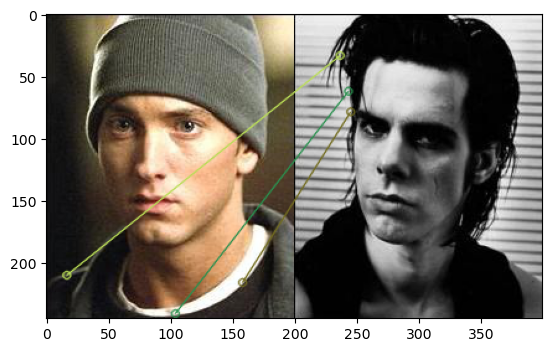

Highest Similarity Score: [[0.80089676]]
Row 17
  Column left: aik
  Column c0: xli
[[0.70527935]]
  Column c1: bzb
[[0.6225198]]
  Column c2: scs
[[0.62952065]]
  Column c3: tgq
[[0.6477871]]
  Column c4: bwx
[[0.6350525]]
  Column c5: jws
[[0.674012]]
  Column c6: azq
[[0.6871058]]
  Column c7: csd
[[0.6869476]]
  Column c8: wji
[[0.685266]]
  Column c9: loh
[[0.5672548]]
  Column c10: jhi
[[0.65526056]]
  Column c11: gpj
[[0.65293294]]
  Column c12: zgx
[[0.687927]]
  Column c13: ump
[[0.5907959]]
  Column c14: dap
[[0.6605227]]
  Column c15: vjq
[[0.6904371]]
  Column c16: tlg
[[0.7001734]]
  Column c17: eba
[[0.68327546]]
  Column c18: pvr
[[0.60810035]]
  Column c19: gwf
[[0.5763002]]


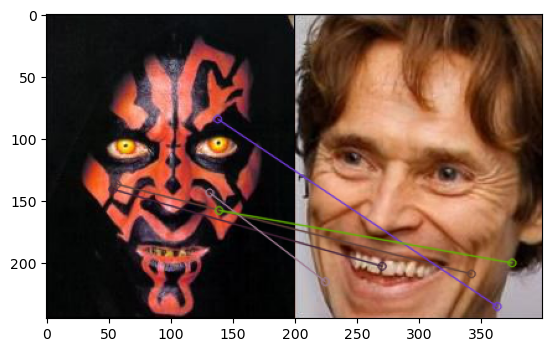

Highest Similarity Score: [[0.70527935]]
Row 18
  Column left: aiv
  Column c0: wgy
[[0.67930734]]
  Column c1: ebm
[[0.744903]]
  Column c2: bty
[[0.70720094]]
  Column c3: azz
[[0.6632548]]
  Column c4: eii
[[0.7557221]]
  Column c5: mki
[[0.71822053]]
  Column c6: tvy
[[0.6086085]]
  Column c7: ypa
[[0.7022538]]
  Column c8: kti
[[0.7728692]]
  Column c9: dbg
[[0.65448195]]
  Column c10: zjp
[[0.6856826]]
  Column c11: ldd
[[0.60754216]]
  Column c12: nsd
[[0.7032999]]
  Column c13: bdz
[[0.7355955]]
  Column c14: pny
[[0.67521197]]
  Column c15: dvs
[[0.7450587]]
  Column c16: sta
[[0.6617809]]
  Column c17: lkd
[[0.6344047]]
  Column c18: oha
[[0.7091749]]
  Column c19: rye
[[0.694048]]


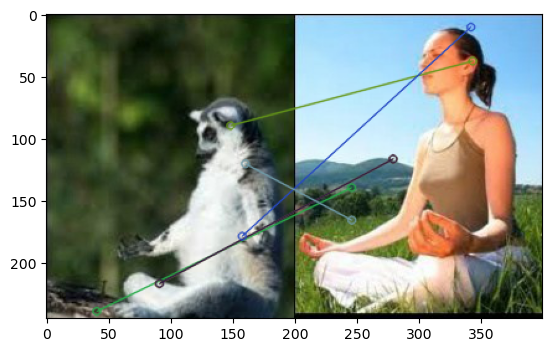

Highest Similarity Score: [[0.7728692]]
Row 19
  Column left: ajf
  Column c0: oar
[[0.6719892]]
  Column c1: cty
[[0.6828437]]
  Column c2: lbg
[[0.7334821]]
  Column c3: tkp
[[0.6376925]]
  Column c4: dsk
[[0.65724933]]
  Column c5: vsj
[[0.6653882]]
  Column c6: jws
[[0.7764926]]
  Column c7: mrg
[[0.63816273]]
  Column c8: haf
[[0.6418643]]
  Column c9: aoo
[[0.7556726]]
  Column c10: aat
[[0.66779596]]
  Column c11: zuf
[[0.64709204]]
  Column c12: sta
[[0.5546292]]
  Column c13: zla
[[0.7214782]]
  Column c14: obn
[[0.6331511]]
  Column c15: lct
[[0.6769763]]
  Column c16: gis
[[0.76181054]]
  Column c17: ehh
[[0.65341914]]
  Column c18: zto
[[0.7265363]]
  Column c19: mto
[[0.6307429]]


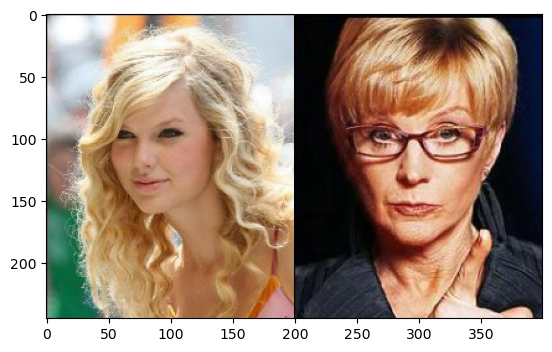

Highest Similarity Score: [[0.7764926]]


In [ ]:
show_test_case(siamese_model,row_number=20)